# FFT for synthetic data
---

In [9]:
from data._main import get_dataset
from omegaconf import OmegaConf

import numpy as np
from scipy.optimize import curve_fit
import torch
import matplotlib.pyplot as plt

In [10]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [11]:
dataset['worm0']['calcium_data'].shape

torch.Size([2879, 302])

In [12]:
def compute_R2(y_observed, y_predicted):
    # Calculate the mean of the observed data points
    mean_y = np.mean(y_observed)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_observed - mean_y) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_observed - y_predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


def approximate_exponential_decay(single_worm_dataset):

    # Define the function to fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    # Define the function to fit
    def rational_func(x, a, b, c):
        return a * 1/x**b + c

    calcium = single_worm_dataset["calcium_data"]
    mask = single_worm_dataset["named_neurons_mask"]
    dt = single_worm_dataset["resample_median_dt"]

    data = calcium[:, mask]

    fft_data = torch.fft.rfft(data, dim=0) # only the real part
    fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt) # only the positive frequencies

    # Convert fft_data and fft_freqs to numpy for use with curve_fit
    fft_data_np = fft_data.detach().numpy()
    fft_freqs_np = fft_freqs.detach().numpy()

    # Power spectrum
    magnitude_spectrum = np.abs(fft_data_np)

    # Phase spectrum
    phase_spectrum = np.angle(fft_data_np)

    # Fit function to each column of data in the power spectrum
    num_neurons = fft_data_np.shape[1]
    fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
    fit_quality = np.zeros(num_neurons)  # for storing the quality of fit

    for i in range(num_neurons):
        try:
            popt, pcov = curve_fit(func, fft_freqs_np, magnitude_spectrum[:, i])
        except RuntimeError:
            print("Error - curve_fit failed")
            continue
        fit_params[i, :] = popt # each row is a, b, and c for a neuron
        #fit_quality[i] = np.sum((magnitude_spectrum[:, i] - func(fft_freqs_np, *popt)) ** 2) # calculate RSS
        #fit_quality[i] = np.sqrt(fit_quality[i]/len(magnitude_spectrum[:, i])-2) # calculate RSE
        fit_quality[i] = compute_R2(magnitude_spectrum[:, i], func(fft_freqs_np, *popt)) # calculate R2

    # Generate x values
    f = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=fft_freqs_np.size)

    # Plot each fitted curve
    exponential_fits = np.zeros_like(fft_data_np)

    for i in range(num_neurons):
        # Generate y values for this curve
        exponential_fits[:, i] = func(f, *fit_params[i])
        
    return fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality

In [13]:
fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(dataset['worm0'])

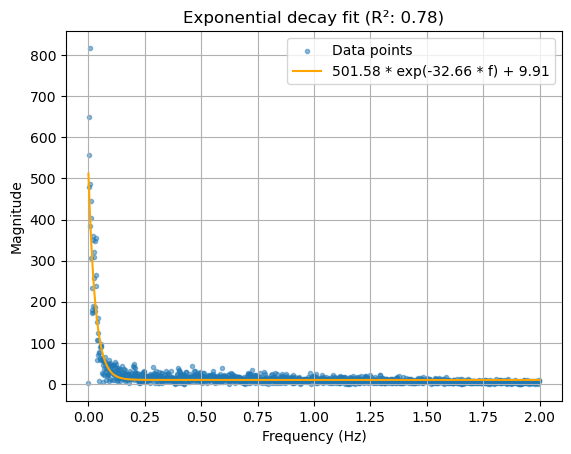

In [14]:
neuron_idx = 7
plt.scatter(fft_freqs_np[:], magnitude_spectrum[:, neuron_idx], marker='.', label='Data points', alpha=0.5)
fit_label = '{} * exp(-{} * f) + {}'.format(round(fit_params[neuron_idx, 0], 2), round(fit_params[neuron_idx, 1], 2), round(fit_params[neuron_idx, 2], 2))
plt.plot(fft_freqs_np[:], exponential_fits[:, neuron_idx], color='orange', label=fit_label)
plt.title('Exponential decay fit (R²: {})'.format(round(fit_quality[neuron_idx], 2)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
import scipy.fftpack as fft

def synthesize_time_series(exponential_fits, time_steps, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    num_freqs = exponential_fits.shape[0]
    synthetic_data = np.zeros((time_steps, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(0.0, 1.8, num_freqs) # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return synthetic_data

In [16]:
synthetic_data = synthesize_time_series(exponential_fits, dataset['worm0']['calcium_data'].shape[0], random_seed=42)

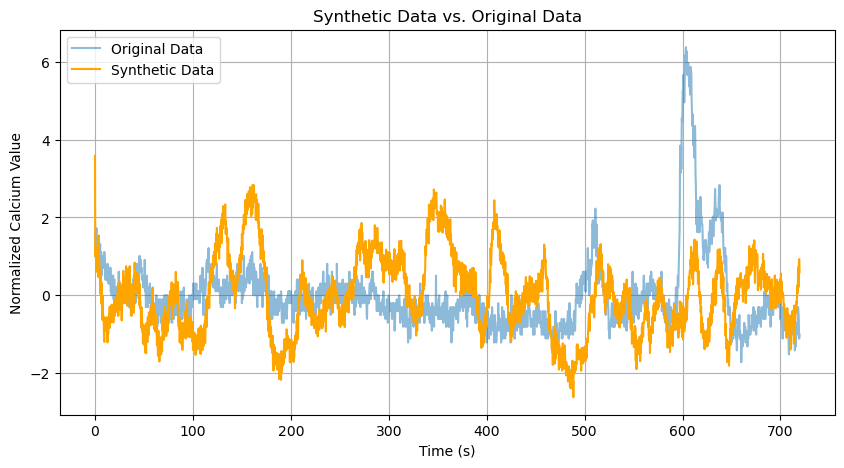

In [17]:
# Scale the synthetic data and original data with min_max scaling along dimension 0
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
synthetic_data = scaler.fit_transform(synthetic_data)
dataset['worm0']['calcium_data'] = scaler.fit_transform(dataset['worm0']['calcium_data'])

calcium_data = dataset['worm0']['calcium_data']
mask = dataset['worm0']['named_neurons_mask']
data = calcium_data[:, mask]

time_steps = data.shape[0]
time_vec = np.arange(time_steps) * 0.25

# Plot the synthetic data and original data
neuron_idx = 7
plt.figure(figsize=(10, 5))
plt.plot(time_vec, data[:, neuron_idx], label='Original Data', alpha=0.5)
plt.plot(time_vec, synthetic_data[:, neuron_idx], color='orange', label='Synthetic Data')
plt.legend()
plt.title("Synthetic Data vs. Original Data")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Calcium Value")
plt.grid(True)
plt.show()

## Phase distribution

In [19]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [20]:
fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(dataset['worm0'])

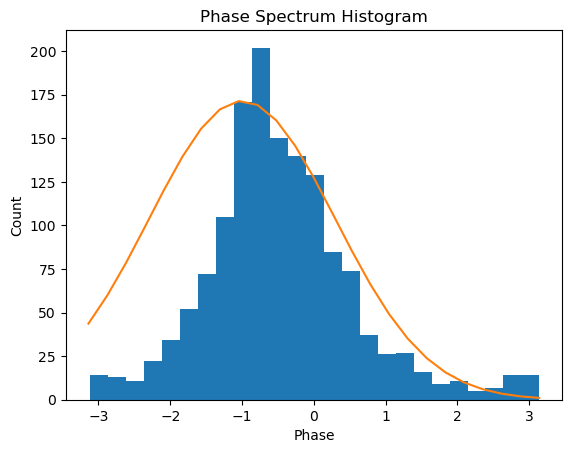

In [27]:
oneNeuronPhase = phase_spectrum[:, 0]

# Plot phase spectrum histogram
plt.hist(oneNeuronPhase, bins=25)
plt.xlabel("Phase")
plt.ylabel("Count")
plt.title("Phase Spectrum Histogram")

# Fit a Gaussian to the phase spectrum histogram
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

popt, pcov = curve_fit(gaussian, np.linspace(-5, 5, num=25), np.histogram(oneNeuronPhase, bins=25)[0])

# Plot the Gaussian fit
plt.plot(np.linspace(-3.14, 3.14, num=25), gaussian(np.linspace(-3.14, 3.14, num=25), *popt))
plt.xlabel("Phase")
plt.ylabel("Count")
plt.title("Phase Spectrum Histogram")
plt.show()

The phases of a single neuron signal itself can't be approximated by a gaussian function (it fails the Shapiro-Wilk test).

But what about the mean of the neuron phases? Do they follow a gaussian distribution?

In [30]:
# Pipeline for phase distribution: compute the mean of the phases for each neuron of every individual

dataset_names = ['Flavell2023', 'Kato2015', 'Nichols2017', 'Skora2018', 'Uzel2022', 'Kaplan2020']

phase_distribution = np.zeros((143, 302, 1)) # (individual, neuron, mu)
exp_decay_params = np.zeros((143, 302, 3)) # (individual, neuron, (a, b, c))

worm_count = 0

for ds_name in dataset_names:
    # Load a single dataset
    dataset = get_dataset(OmegaConf.create({"dataset": {'name': ds_name}}))

    # Iterate over worms in the dataset
    for wormid, data in dataset.items():
        fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(data)

        if (not fit_params is None) and (not phase_spectrum is None):
            for i, named_neuron in enumerate(data['slot_to_named_neuron']):

                phase_distribution[worm_count, named_neuron, 0] = np.mean(phase_spectrum[:, i]) # mu

                exp_decay_params[worm_count, named_neuron, 0] = fit_params[i, 0] # a
                exp_decay_params[worm_count, named_neuron, 1] = fit_params[i, 1] # b
                exp_decay_params[worm_count, named_neuron, 2] = fit_params[i, 2] # c

        worm_count += 1

Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Error - curve_fit failed
Chosen dataset(s): ['Kato2015']
Num. worms: 12

Chosen dataset(s): ['Nichols2017']
Num. worms: 44

Chosen dataset(s): ['Skora2018']
Num. worms: 12

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

Chosen dataset(s): ['Kaplan2020']
Num. worms: 19



In [33]:
from scipy.stats import shapiro

test_counter = 0
gdist = 0

for i in range(302):
    neuron_phase_dist_mean = phase_distribution[:, i, 0]
    mask = np.where(neuron_phase_dist_mean != 0)[0]

    data_to_test = neuron_phase_dist_mean[mask]

    # test normality of the mean phase distribution
    if len(data_to_test) > 3:
        stat, p = shapiro(data_to_test)
        test_counter += 1
        print('Shapiro-Wilk test for normality for neuron {}: {}'.format(i, p>0.05)) # True if normal dist
        if p>0.05:
            gdist += 1

print('')
print(gdist/test_counter)

Shapiro-Wilk test for normality for neuron 0: False
Shapiro-Wilk test for normality for neuron 1: False
Shapiro-Wilk test for normality for neuron 2: True
Shapiro-Wilk test for normality for neuron 3: True
Shapiro-Wilk test for normality for neuron 6: False
Shapiro-Wilk test for normality for neuron 7: True
Shapiro-Wilk test for normality for neuron 8: True
Shapiro-Wilk test for normality for neuron 9: False
Shapiro-Wilk test for normality for neuron 10: True
Shapiro-Wilk test for normality for neuron 11: True
Shapiro-Wilk test for normality for neuron 12: False
Shapiro-Wilk test for normality for neuron 13: False
Shapiro-Wilk test for normality for neuron 14: True
Shapiro-Wilk test for normality for neuron 15: True
Shapiro-Wilk test for normality for neuron 16: True
Shapiro-Wilk test for normality for neuron 17: True
Shapiro-Wilk test for normality for neuron 18: True
Shapiro-Wilk test for normality for neuron 19: True
Shapiro-Wilk test for normality for neuron 20: True
Shapiro-Wilk t

The mean phase of 65% of the neurons can be represented as a gaussian distribution!

=> hipothesis: all mean neuron phases can be approximated by a gaussian distribution

In [ ]:
mean_phases_mean = phase_distribution[:, :, 0].mean(axis=0)
mean_phases_std = phase_distribution[:, :, 0].std(axis=0)

In [ ]:
302 - np.count_nonzero(mean_phases_mean != 0)

85

We don't have data of 85 neurons!

=> We will conside the distribution of these neurons as a normal distribution with mean equal the of the (mean_phases_mean), and the std equal the mean of (mean_phases_std).

In [ ]:
mask = np.where(mean_phases_mean == 0)[0] # missing values mask
mean_phases_mean[mask] = np.mean(mean_phases_mean[~mask])
mean_phases_std[mask] = np.mean(mean_phases_std[~mask])

In [ ]:
# Save the mean phase distribution
#np.save('mean_phase_distribution.npy', mean_phases_mean)
#np.save('mean_phase_distribution_std.npy', mean_phases_std)

## Sines

In [ ]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 12
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000_sines"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)

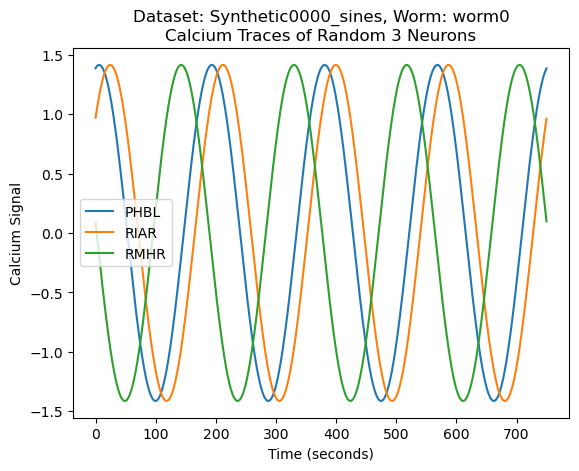

In [ ]:
import pickle
from visualize._utils import plot_worm_data

# Load synthetic dataset
with open(f"../data/processed/neural/{file_name}.pickle", "rb") as f:
    dataset = pickle.load(f)

# Plot the first few calcium traces for the first worm
plot_worm_data(dataset["worm0"], num_neurons=3, smooth=False)

## FFT

In [ ]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 12
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000_sines"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)